# Getting started with `sbi`

Note, you can find the original version of this notebook at [https://github.com/sbi-dev/sbi/blob/main/tutorials/00_getting_started_flexible.ipynb](https://github.com/sbi-dev/sbi/blob/main/tutorials/00_getting_started_flexible.ipynb) in the `sbi` repository.

`sbi` provides a simple interface to run state-of-the-art algorithms for simulation-based inference.

**The overall goal of simulation-based inference is to algorithmically identify model parameters which are consistent with data.**

In this tutorial we demonstrate how to get started with the `sbi` toolbox and how to perform parameter inference on a simple model.

In [5]:
import torch

from sbi.analysis import pairplot
from sbi.inference import SNPE, simulate_for_sbi
from sbi.utils import BoxUniform
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

## Parameter inference in a linear Gaussian example



Each of the implemented inference methods takes three inputs:  
1. observational data (or summary statistics thereof) - _the observations_  
2. a candidate (mechanistic) model - _the simulator_  
3. prior knowledge or constraints on model parameters - _the prior_

If you are new to simulation-based inference, please first read the information on the [homepage of the website](https://sbi-dev.github.io/sbi/) to familiarise with the motivation and relevant terms.

For this illustrative example we consider a model _simulator_ that takes in 3 parameters ($\theta$). For simplicity, the _simulator_ outputs simulations of the same dimensionality and adds 1.0 and some Gaussian noise to the parameter set. 

> Note: This is where you instead would use your specific  _simulator_ with its parameters.

For the 3-dimensional parameter space we consider a uniform _prior_ between [-2,2].

> Note: This is where you would incorporate prior knowlegde about the parameters you want to infer, e.g., ranges known from literature. 

In [6]:
num_dim = 3

def simulator(theta):
    # linear gaussian
    return theta + 1.0 + torch.randn_like(theta) * 0.1

prior = BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))

We have to ensure that your _simulator_ and _prior_ adhere to the requirements of `sbi` such as returning `torch.Tensor`s in a standardised shape. 

You can do so with the `process_simulator()` and `process_prior()` functions, which prepare them appropriately. Finally, you can call `check_sbi_input()` to make sure they are consistent which each other.

In [7]:
# Check prior, return PyTorch prior.
prior, num_parameters, prior_returns_numpy = process_prior(prior)

# Check simulator, returns PyTorch simulator able to simulate batches.
simulator = process_simulator(simulator, prior, prior_returns_numpy)

# Consistency check after making ready for sbi.
check_sbi_inputs(simulator, prior)

Next, we instantiate the inference object. In this example, we will use neural perform posterior estimation (NPE):

> Note: In the `sbi` toolbox, NPE is run by using the `SNPE` (Sequential NPE) class for only one iteration of simulation and training. 

> Note: This is where you could specify an alternative inference object such as (S)NRE for ratio estimation or (S)NLE for likelihood estimation. Here, you can see [all implemented methods](https://sbi-dev.github.io/sbi/tutorial/16_implemented_methods/).

In [8]:
inference = SNPE(prior=prior)

Next, we need simulations, or more specifically, pairs of parameters $\theta$ which we sample from the _prior_ and corresponding simulations $x = \mathrm{simulator} (\theta)$. The `sbi` helper function called `simulate_for_sbi` allows to parallelize your code with `joblib`.

 > Note: If you already have your own parameters, simulation pairs which were generated elsewhere (e.g., on a compute cluster), you would add them here.  


In [11]:
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=2000)
print("theta.shape", theta.shape)
print("x.shape", x.shape)

Running 2000 simulations.:   0%|          | 0/2000 [00:00<?, ?it/s]

theta.shape torch.Size([2000, 3])
x.shape torch.Size([2000, 3])


We then pass the simulated data to the inference object. Both `theta` and `x` should be a `torch.Tensor` of type `float32`.

In [12]:
inference = inference.append_simulations(theta, x)

Next, we train the _neural density estimator_ to learn the association between the simulated data (or data features) and the underlying parameters:

In [13]:
density_estimator = inference.train()

 Neural network successfully converged after 81 epochs.

Finally, we use this _density estimator_ to build the posterior distribution $p(\theta|x)$, i.e., the distributions over paramters $\theta$ given observation $x$. 

The `posterior` can then be used to (among other features which go beyond the scope of this introductory tutorial) sample parameters $\theta$ from the posterior via `.sample()`, i.e., parameters that are likely given the observation $x$. 

We can also get log-probabilities under the posterior via `.log_prob()`, i.e., we can evaluate the likelihood of parameters $\theta$ given the observation $x$. 

In [14]:
posterior = inference.build_posterior(density_estimator)

print(posterior) # prints how the posterior was trained

Posterior conditional density p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


## Visualisations of the inferred posterior for a new observation

Let's say we have made some observation $x_{obs}$ for which we now want to infer the posterior:

> Note: this is where your experimental observation would come in. For real observations, of course, you would not have access to the ground truth $\theta$. 

In [15]:
theta_true = prior.sample((1,))
# generate our observation
x_obs = simulator(theta_true)

 Given this observation, we can sample from the posterior $p(\theta|x_{obs})$ and visualise the univariate and pairwise marginals for the three parameters via `analysis.pairplot()`.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

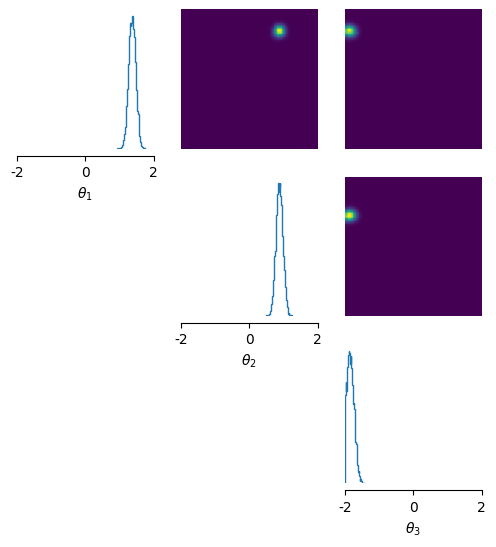

In [17]:
samples = posterior.sample((10000,), x=x_obs)
_ = pairplot(samples, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(6, 6),labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"])

## Assessing the posterior for the known $\theta, x$ - pair 

For this special case, we have access to the ground-truth parameters that generated the observation. We can thus assess if the inferred distributions over the parameters match the parameters $\theta_{true}$ we used to generate our test observation $x_{obs}$.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

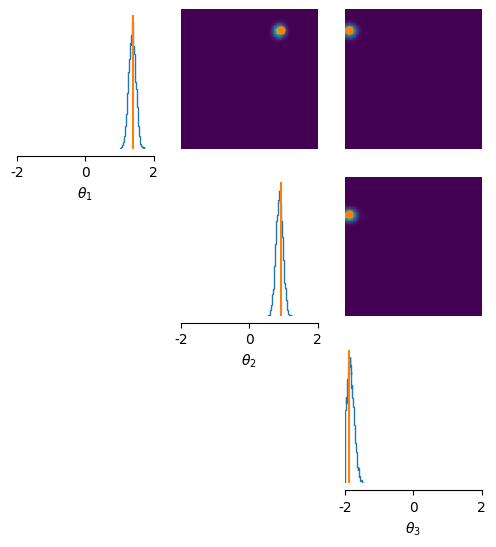

In [19]:
samples = posterior.sample((10000,), x=x_obs)
_ = pairplot(samples, points=theta_true, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(6, 6), labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"])

The log-probability should ideally indicate that the true parameters, given the corresponding observation, are more likely than a different set of randomly chosen parameters from the prior distribution. 

Relative to the obtained log-probabilities, we can investigate the range of log-probabilities of the parameters sampled from the posterior.

In [20]:
# first sample an alternative parameter set from the prior
theta_diff = prior.sample((1,))

In [21]:
log_probability_true_theta = posterior.log_prob(theta_true, x=x_obs)
log_probability_diff_theta = posterior.log_prob(theta_diff, x=x_obs)
log_probability_samples = posterior.log_prob(samples, x=x_obs)

print( r'high for true theta :', log_probability_true_theta)
print( r'low for different theta :', log_probability_diff_theta)
print( r'range of posterior samples: min:', torch.min(log_probability_samples),' max :', torch.max(log_probability_samples))


high for true theta : tensor([3.7909])
low for different theta : tensor([-326.5020])
range of posterior samples: min: tensor(-8.1930)  max : tensor(4.0474)


## Next steps

To learn more about the capabilities of `sbi`, you can head over to the tutorial on [inferring parameters for multiple observations ](https://sbi-dev.github.io/sbi/tutorial/01_gaussian_amortized/) which introduces the concept of amortization. 

Alternatively, for an example with an __actual__ simulator, you can read our [example for a scientific simulator from neuroscience](https://sbi-dev.github.io/sbi/examples/00_HH_simulator/).